## Cleaning relevance dataset and query logs

In [221]:
import pandas as pd

relevance_df_1 = pd.read_excel("./data/QL_IT_oct_7_exp_on_results.xlsx")
relevance_df_2 = pd.read_excel("./data/QL_IT_oct_8_exp_on_results.xlsx")
relevance_df_3 = pd.read_excel("./data/QL_IT_oct_10_exp_on_results.xlsx")
rel_df_other = pd.read_excel("./data/QL_IT_exp_on_results.xlsx")
emotional_rel_df = pd.read_excel("./data/QL_IT_oct__exp_on_results.xlsx")
relevance_df = pd.concat([relevance_df_1, relevance_df_2, relevance_df_3, rel_df_other, emotional_rel_df])
# relevance_df = pd.concat([relevance_df_1, relevance_df_2, relevance_df_3])
relevance_df["user_query"] = [query.strip() for query in relevance_df["user_query"]] # removing leading/trailing white spaces in queries
relevance_df = relevance_df[['session_id', 'user_query', 'url', 'source', 'title', 'snippet',
       'position', 'TextSample', 'TextSample-Tokenized',
       'tagged_TextSample-Tokenized']]
relevance_df.drop_duplicates(inplace=True)
relevance_df.reset_index(drop=True, inplace=True)
relevance_df.to_excel("./data/search_results.xlsx", index=False)

clicked_df_1 = pd.read_excel("./data/QL_Oct 7_clicked.xlsx")
clicked_df_2 = pd.read_excel("./data/QL_Oct 8_clicked.xlsx")
clicked_df_3 = pd.read_excel("./data/QL_Oct 10_clicked.xlsx")
clicked_df = pd.concat([clicked_df_1, clicked_df_2, clicked_df_3])
clicked_df["Query"] = [query.strip() for query in clicked_df["Query"]] # removing leading/trailing white spaces in queries
clicked_df.drop_duplicates(inplace=True)
clicked_df.reset_index(drop=True, inplace=True)
clicked_df.to_excel("./data/clicked_results.xlsx", index=False)

In [222]:
print(len(clicked_df_1["Query"].unique()), len(clicked_df_2["Query"].unique()), len(clicked_df_3["Query"].unique())) 
print(len(clicked_df["Query"].unique()))
print(len(relevance_df_1["user_query"].unique()), len(relevance_df_2["user_query"].unique()), len(relevance_df_3["user_query"].unique()), len(rel_df_other["user_query"].unique()), len(emotional_rel_df["user_query"].unique()))
print(len(relevance_df["user_query"].unique()))

40 16 18
70
45 22 20 211 82
282


In [223]:
relevance_df.columns

Index(['session_id', 'user_query', 'url', 'source', 'title', 'snippet',
       'position', 'TextSample', 'TextSample-Tokenized',
       'tagged_TextSample-Tokenized'],
      dtype='object')

In [224]:
relevance_df.head(1)

,session_id,user_query,url,source,title,snippet,position,TextSample,TextSample-Tokenized,tagged_TextSample-Tokenized
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,R,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,1,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de..."


In [225]:
clicked_df.head(1)

,Query,url,title,position
0,le conseguenze negative della distruzione dell...,http://www.eniscuola.net/argomento/foresta-tro...,Conseguenze della deforestazione - eniscuola.net,5


In [226]:
len(relevance_df), len(clicked_df)

(3432, 111)

In [227]:
def get_search_session_stats(relevance_df, df_name):
    session_stats = []

    for session_id in relevance_df["session_id"].unique():
        search_session = relevance_df.loc[relevance_df["session_id"]==session_id]
        for query in search_session["user_query"].unique():
            search_results = search_session.loc[search_session["user_query"]==query]
            session_stats.append([session_id, query, len(search_results), len(search_results["url"].unique())])

    df = pd.DataFrame(session_stats, columns=["session_id", "user_query", "num_results", "num_unique_urls"])
    df.to_excel("./data/search_session_stats_"+df_name+".xlsx", index=False)
    df

In [228]:
get_search_session_stats(relevance_df, df_name="relevance_df")

In [229]:
print(len(relevance_df["url"].unique()), len(relevance_df["TextSample"].unique()), len(relevance_df["title"].unique()), len(relevance_df["snippet"].unique()))

1556 1995 1612 1965


In [230]:
rows_to_remove = []
full_session_removed = []

for session_id in relevance_df["session_id"].unique():
    search_session = relevance_df.loc[relevance_df["session_id"]==session_id] # search results for a session id
    print("Session ID: ", session_id)
    duplicate_counter = 0
    for query in search_session["user_query"].unique():
        search_results = relevance_df.loc[(relevance_df["session_id"]==session_id) & (relevance_df["user_query"]==query)] # search results for a query within a session
        if len(search_results) != len(search_results["url"].unique()): # check if the same webpage appeared more than once in the SERP for query during a given session
            print("\tQuery with duplicate URLs in SERP: ", query)
            for url in search_results["url"].unique():
                if len(relevance_df.loc[(relevance_df["session_id"]==session_id) & (relevance_df["user_query"]==query) & (relevance_df["url"]==url)]) > 1:
                    rows_to_remove += list(relevance_df.loc[(relevance_df["session_id"]==session_id) & (relevance_df["user_query"]==query) & (relevance_df["url"]==url)].index)
                    print("\t\tDuplicate URL: ", url, list(relevance_df.loc[(relevance_df["session_id"]==session_id) & (relevance_df["user_query"]==query) & (relevance_df["url"]==url)].index))
                    duplicate_counter += len(list(relevance_df.loc[(relevance_df["session_id"]==session_id) & (relevance_df["user_query"]==query) & (relevance_df["url"]==url)].index))
    print(duplicate_counter," results to be removed from session: ", session_id)
    if duplicate_counter==len(search_session):
        print("*******************************************")
        print("WARNING!! Full session ", session_id, " has to be removed")
        full_session_removed.append(session_id)
        print("*******************************************")
    print("Updated list of rows to remove: ", rows_to_remove)
    print()

print("Number of sessions to be removed completely: ", len(full_session_removed))
    
relevance_df_cleaned = relevance_df.drop(relevance_df.index[rows_to_remove])
relevance_df_cleaned.reset_index(inplace=True, drop=True)
relevance_df_cleaned.to_excel("./data/search_results_cleaned.xlsx", index=False)
relevance_df_cleaned.head(2)

Session ID:  393
0  results to be removed from session:  393
Updated list of rows to remove:  []

Session ID:  395
	Query with duplicate URLs in SERP:  Dove si trova l isola di plastica
		Duplicate URL:  https://www.repubblica.it/ambiente/2018/03/22/news/l_isola_di_plastica_del_pacifico_e_sempre_piu_enorme-191962940/ [11, 20]
		Duplicate URL:  http://www.saperescienza.it/rubriche/geologia/l-isola-di-plastica-18-07-2014/200-l-isola-di-plastica-18-07-2014 [16, 21]
	Query with duplicate URLs in SERP:  Il ghiacciaio piÃ…Â« in via di estinzione
		Duplicate URL:  https://it.m.wikipedia.org/wiki/Ghiacciaio_del_Calderone [33, 34]
	Query with duplicate URLs in SERP:  Le regole per tenere le spiagge pulite
		Duplicate URL:  https://www.105.net/gallery/tutto-news/249890/10-consigli-per-mantenere-le-spiagge-pulite.html [43, 52]
		Duplicate URL:  https://www.ecoo.it/articolo/spiagge-italiane-ecco-le-regole-per-trattarle-bene/21287/ [44, 45]
		Duplicate URL:  https://www.laleggepertutti.it/25788_spi

,session_id,user_query,url,source,title,snippet,position,TextSample,TextSample-Tokenized,tagged_TextSample-Tokenized
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,R,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,1,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de..."
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,NR,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,2,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in..."


In [231]:
get_search_session_stats(relevance_df=relevance_df_cleaned, df_name="relevance_df_cleaned")

In [232]:
print(len(rows_to_remove), len(relevance_df)-len(relevance_df_cleaned))

314 314


In [233]:
print(len(relevance_df_cleaned["session_id"].unique()), len(relevance_df["session_id"].unique()))

94 94


## Combining query log and relevance judgments into one dataset

In [234]:
import pandas as pd

relevance_df = pd.read_excel("./data/search_results_cleaned.xlsx")
relevance_df.head()

,session_id,user_query,url,source,title,snippet,position,TextSample,TextSample-Tokenized,tagged_TextSample-Tokenized
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,R,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,1,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de..."
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,NR,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,2,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in..."
2,393,le conseguenze negative della distruzione dell...,https://www.elledecor.com/it/lifestyle/a280666...,R,Le conseguenze degli incendi della foresta ama...,Il Brasile sta vivendo la piÃ¹ grande ondata d...,3,Le conseguenze degli incendi della foresta ama...,"['Le', 'conseguenze', 'degli', 'incendi', 'del...","[('Le', 'NNP'), ('conseguenze', 'NN'), ('degli..."
3,393,le conseguenze negative della distruzione dell...,https://www.informazioneambiente.it/deforestaz...,NR,Cause e conseguenze della deforestazione ambie...,Le conseguenze della deforestazione. Ma a cosa...,4,Cause e conseguenze della deforestazione ambie...,"['Cause', 'e', 'conseguenze', 'della', 'defore...","[('Cause', 'NNP'), ('e', 'NN'), ('conseguenze'..."
4,393,le conseguenze negative della distruzione dell...,http://www.eniscuola.net/argomento/foresta-tro...,R,Conseguenze della deforestazione - eniscuola.net,Conseguenze della deforestazione. Le foreste h...,5,Conseguenze della deforestazione - eniscuola.n...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de..."


In [235]:
weird_ones = 0
weird_queries_count = 0
weird_queries = []
weird_titles = []

for query in clicked_df["Query"].unique():
    weird_query_flag = 0
    temp = clicked_df.loc[clicked_df["Query"]==query]
    for _, row in temp.iterrows():
        user_query = row["Query"]
        assert user_query==query
        clicked_url = row["url"]
        clicked_title = row["title"]
        clicked_position = row["position"]
        clicked_results = clicked_df.loc[(clicked_df["Query"]==user_query)&(clicked_df["url"]==clicked_url)&(clicked_df["title"]==clicked_title)&(clicked_df["position"]==clicked_position)]
        if len(clicked_results)>1:
            print(clicked_results)
            break
        found_result = relevance_df.loc[(relevance_df["user_query"]==user_query) & (relevance_df["title"] ==clicked_title) & (relevance_df["url"]==clicked_url) & (relevance_df["position"]==clicked_position)]
        if len(found_result) > 1:
            if len(found_result)!=len(found_result["session_id"].unique()):
                weird_query_flag = 1
            # print(found_result["session_id"].unique())
            # print(user_query)
            # print(clicked_title)
            # print(clicked_url)
            # print(clicked_position)
            # print(found_result["snippet"].unique())
            # print(found_result["TextSample"].unique())
            weird_ones += 1
            weird_titles.append(clicked_title)
    if weird_query_flag == 1:
        weird_queries_count += 1
        weird_queries.append(query)

print(weird_queries_count)
for query in weird_queries:
    print(query)

0


In [236]:
clicked_df.head()

,Query,url,title,position
0,le conseguenze negative della distruzione dell...,http://www.eniscuola.net/argomento/foresta-tro...,Conseguenze della deforestazione - eniscuola.net,5
1,BiodiversitÃƒÂ¡,http://www.globalissues.org/article/170/why-is...,Why Is Biodiversity Important? Who Cares? â€” ...,9
2,perchÃƒÂ© gli orsi polari si stanno estinguend...,http://www.ilcambiamento.it/articoli/orsi_pola...,"Orsi polari, Ã¨ allarme estinzione. Lo conferm...",5
3,Lisola di plastica cosa ÃƒÂ¨,http://www.lascimmiaviaggiatrice.it/isola-di-p...,isola di plastica che cos'Ã¨ e perchÃ¨ non puÃ...,3
4,Quanto psa lisola di plastica,http://www.meteoweb.eu/2018/03/inquinamento-oc...,Inquinamento: la piÃ¹ grande isola ... - meteo...,6


In [237]:
relevance_df.head(1)

,session_id,user_query,url,source,title,snippet,position,TextSample,TextSample-Tokenized,tagged_TextSample-Tokenized
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,R,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,1,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de..."


In [238]:
print(len(relevance_df), len(clicked_df), len(relevance_df.loc[relevance_df["user_query"].isin(clicked_df["Query"].unique())]))
print(len(relevance_df["user_query"]), len(clicked_df["Query"]))
print(len(relevance_df["user_query"].unique()), len(clicked_df["Query"].unique()))
print(clicked_df["Query"].value_counts())

3118 111 670
3118 111
282 70
Query
Di cosa si occupa il WWF ?                                         4
Isola di plastica                                                  4
Qual ÃƒÂ© la causa della riduzione del lago Aral                   3
Conseguenze negative della distruzione della foresta amazzonica    3
perchÃƒÂ© gli orsi polari si stanno estinguendo sito babbanas      3
                                                                  ..
Peso bottiglia di plastica                                         1
spiagge bandiera blu 2019                                          1
Spiagge con la bandiera della pulizia                              1
Spiagge con bandiera blu                                           1
CosÃƒÂ¨ Ã„Â¾isola di plastica                                      1
Name: count, Length: 70, dtype: int64


In [239]:
rel_df_queries = list(relevance_df["user_query"].unique())
click_df_queries = list(clicked_df["Query"].unique())

count = 0
for query in click_df_queries:
    if query not in rel_df_queries:
        print(query)
        count+=1

print("Number of queries with no relevance judgments: ", count)

Number of queries with no relevance judgments:  0


In [240]:
missing_clicked_result = 0

for _, row in clicked_df.iterrows():
    query = row["Query"]
    title = row["title"]
    url = row["url"]
    position = row["position"]

    search_result = relevance_df.loc[(relevance_df["user_query"]==query) & (relevance_df["title"]==title) & (relevance_df["url"]==url) & (relevance_df["position"]==position)]
    if len(search_result) == 0:
        missing_clicked_result +=1 
        print(row, end="\n\n")

print("Number of clicked results missing from relevance dataset: ", missing_clicked_result)

Query                                         BiodiversitÃƒÂ¡
url         http://www.globalissues.org/article/170/why-is...
title       Why Is Biodiversity Important? Who Cares? â€” ...
position                                                    9
Name: 1, dtype: object

Query                            Lisola di plastica cosa ÃƒÂ¨
url         http://www.lascimmiaviaggiatrice.it/isola-di-p...
title       isola di plastica che cos'Ã¨ e perchÃ¨ non puÃ...
position                                                    3
Name: 3, dtype: object

Query                           Quanto psa lisola di plastica
url         http://www.meteoweb.eu/2018/03/inquinamento-oc...
title       Inquinamento: la piÃ¹ grande isola ... - meteo...
position                                                    6
Name: 4, dtype: object

Query                       Dove si trova l isola di plastica
url         http://www.saperescienza.it/rubriche/geologia/...
title       L'isola di plastica - SapereScienza L'isola di..

In [241]:
combined_data = []

for query in click_df_queries:
    search_results = relevance_df.loc[relevance_df["user_query"]==query] # all SE results yielded for a query
    # clicked_results = clicked_df.loc[clicked_df["Query"]==query] # all results clicked for same query
    for _, row in search_results.iterrows():
        session_id = row["session_id"]
        user_query = row["user_query"]
        title = row["title"]
        url = row["url"]
        snippet = row["snippet"]
        textsample = row["TextSample"]
        textsample_tokens = row["TextSample-Tokenized"]
        textsample_pos = row["tagged_TextSample-Tokenized"]
        position = row["position"]
        relevant = row["source"]

        clicked_result_found = clicked_df.loc[(clicked_df["Query"]==query) & (clicked_df["url"]==url) & (clicked_df["title"]==title) & (clicked_df["position"]==position)] # find the clicked result corresponding to (query+url+title+SERP position) combo
        assert len(clicked_result_found) <= 1 
        
        if len(clicked_result_found)==1:
            click = "C"
        elif len(clicked_result_found)==0:
            click="NC"
        
        combined_data.append([session_id, user_query, url, title, snippet, textsample, textsample_tokens, textsample_pos, position, relevant, click])


#     clicked_urls = list(clicked_df.loc[clicked_df["Query"]==query]["url"])
#     resources = relevance_df.loc[relevance_df["user_query"]==query]
#     for _, row in resources.iterrows():
#         session_id = row["session_id"]
#         title = row["title"]
#         snippet = row["snippet"]
#         textsample = row["TextSample"]
#         position = row["position"]
#         relevant = row["source"]
#         url = row["url"]
#         if url in clicked_urls:
#             click = "C"
#         else:
#             click = "NC"

#         combined_data.append([session_id, query,url,title,snippet,textsample, position, relevant, click])
    

combined_data_df = pd.DataFrame(combined_data, columns = ["session_id", "query", "url", "title", "snippet", "text_sample", "text_sample_tokens", "text_sample_pos", "position", "relevant", "click"])
# combined_data_df.drop(["position"], axis=1, inplace=True)
combined_data_df.drop_duplicates(inplace=True, ignore_index=True)
combined_data_df.to_excel("./data/query_log_IT.xlsx", index=False)
print(len(combined_data_df))
combined_data_df.head(2)

670


,session_id,query,url,title,snippet,text_sample,text_sample_tokens,text_sample_pos,position,relevant,click
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",1,R,NC
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in...",2,NR,NC


In [242]:
len(combined_data_df["query"].unique())

70

In [243]:
combined_data_df["query"].value_counts()

query
PerchÃƒÂ¨ gli orsi polari stanno diminuendo drasticamente di numero    20
Spiagge con bandiera blu                                               18
perchÃƒÂ© gli orsi polari si stanno estinguendo                        18
Anno con temperature piÃƒÂ¹ alte                                       12
Dove si trova Ã„Â¾isola di plastica?                                   11
                                                                       ..
Le regole per tenere le spiagge pulite                                  7
Isola di plastica                                                       6
Conseguenze negative della distruzione della foresta amazzonica         6
perchÃƒÂ© gli orsi polari si stanno estinguendo sito babbanas           6
ocean cleanup                                                           5
Name: count, Length: 70, dtype: int64

In [244]:
combined_data_df.groupby(["click", "relevant"]).size()

click  relevant
C      NR            1
       R            86
NC     NR          576
       R             7
dtype: int64

In [251]:
df = pd.DataFrame(columns=relevance_df.columns)

for _, row in clicked_df.iterrows():
    query = row["Query"]
    title = row["title"]
    url = row["url"]
    position = row["position"]

    result = relevance_df.loc[(relevance_df["user_query"]==query) & (relevance_df["title"]==title) & (relevance_df["url"]==url) & (relevance_df["position"]==position)]
    if len(result) == 0:
        print("No search result corresponding to ", (query, title, url, position), " combination.")
    else:
        df = pd.concat([df, result])


No search result corresponding to  ('BiodiversitÃƒÂ¡', 'Why Is Biodiversity Important? Who Cares? â€” Global Issues', 'http://www.globalissues.org/article/170/why-is-biodiversity-important-who-cares', 9)  combination.
No search result corresponding to  ('Lisola di plastica cosa ÃƒÂ¨', "isola di plastica che cos'Ã¨ e perchÃ¨ non puÃ² essere salvata", 'http://www.lascimmiaviaggiatrice.it/isola-di-plastica-che-cose/', 3)  combination.
No search result corresponding to  ('Quanto psa lisola di plastica', 'Inquinamento: la piÃ¹ grande isola ... - meteoweb.eu', 'http://www.meteoweb.eu/2018/03/inquinamento-oceani-isola-plastica/1070775/', 6)  combination.
No search result corresponding to  ('Dove si trova l isola di plastica', "L'isola di plastica - SapereScienza L'isola di plastica - SapereScienza L'isola di plastica - SapereScienza", 'http://www.saperescienza.it/rubriche/geologia/l-isola-di-plastica-18-07-2014/200-l-isola-di-plastica-18-07-2014', 7)  combination.
No search result correspondi

In [253]:
df["source"].value_counts()

source
R     86
NR     1
Name: count, dtype: int64

## Misc

In [38]:
combined_data_excluding_weird_queries = []

for query in click_df_queries:
    if query in weird_queries: # queries within the same session with multiple snippets corresponding to the same web title
        continue
    search_results = relevance_df.loc[relevance_df["user_query"]==query] # all SE results yielded for a query
    clicked_results = clicked_df.loc[clicked_df["Query"]==query] # all results clicked for a query
    for _, row in search_results.iterrows():
        session_id = row["session_id"]
        user_query = row["user_query"]
        title = row["title"]
        url = row["url"]
        snippet = row["snippet"]
        textsample = row["TextSample"]
        textsample_tokens = row["TextSample-Tokenized"]
        textsample_pos = row["tagged_TextSample-Tokenized"]
        position = row["position"]
        relevant = row["source"]

        clicked_result_found = clicked_results.loc[(clicked_results["url"]==url)&(clicked_results["title"]==title)&(clicked_results["position"]==position)] # find the clicked result corresponding to (query+url+title+SERP position) combo
        assert len(clicked_result_found) <= 1 
        
        if len(clicked_result_found)==1:
            click = "C"
        elif len(clicked_result_found)==0:
            click="NC"
        
        combined_data_excluding_weird_queries.append([session_id, query,url,title,snippet,textsample,textsample_tokens, textsample_pos, position, relevant, click])


#     clicked_urls = list(clicked_df.loc[clicked_df["Query"]==query]["url"])
#     resources = relevance_df.loc[relevance_df["user_query"]==query]
#     for _, row in resources.iterrows():
#         session_id = row["session_id"]
#         title = row["title"]
#         snippet = row["snippet"]
#         textsample = row["TextSample"]
#         position = row["position"]
#         relevant = row["source"]
#         url = row["url"]
#         if url in clicked_urls:
#             click = "C"
#         else:
#             click = "NC"

#         combined_data.append([session_id, query,url,title,snippet,textsample, position, relevant, click])
    

combined_data_excluding_weird_queries_df = pd.DataFrame(combined_data_excluding_weird_queries, columns = ["session_id", "query", "url", "title", "snippet", "text_sample", "text_sample_tokens", "text_sample_pos", "position", "relevant", "click"])
# combined_data_df.drop(["position"], axis=1, inplace=True)
combined_data_excluding_weird_queries_df.drop_duplicates(inplace=True, ignore_index=True)
combined_data_excluding_weird_queries_df.to_excel("./data/query_log_IT_excluding_weird_queries.xlsx", index=False)
print(len(combined_data_excluding_weird_queries_df))
combined_data_excluding_weird_queries_df.head(2)

453


,session_id,query,url,title,snippet,text_sample,text_sample_tokens,text_sample_pos,position,relevant,click
0,393,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,Conseguenze della deforestazione - ecoage.it C...,"['Conseguenze', 'della', 'deforestazione', '-'...","[('Conseguenze', 'NNP'), ('della', 'NN'), ('de...",1,R,NC
1,393,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,La deforestazione in Amazzonia - Foresta Amazz...,"['La', 'deforestazione', 'in', 'Amazzonia', '-...","[('La', 'NNP'), ('deforestazione', 'NN'), ('in...",2,NR,NC


In [39]:
len(combined_data_excluding_weird_queries_df["query"].unique())

44

In [40]:
combined_data_excluding_weird_queries_df["query"].value_counts()

query
PerchÃƒÂ¨ gli orsi polari stanno diminuendo drasticamente di numero      20
Spiagge con bandiera blu                                                 18
Anno con temperature piÃƒÂ¹ alte                                         12
Dove si trova l isola di plastica                                        12
le conseguenze negative della distruzione della foresta amazzonica       10
spiagge bandiera blu 2019                                                10
CosÃƒÂ© il buco nel azono                                                10
Nomi spiagge bandiera pulizia                                            10
Temperature estive superano quelle misurate nel 2019                     10
Regole per tenere pulite le spiagge                                      10
Le spiagge piÃ…Â« piÃƒÂ¹ pulite                                          10
Peso bottiglia di plastica                                               10
Spiagge con la bandiera della pulizia                                    10
Cose i

In [41]:
combined_data_excluding_weird_queries_df.groupby(["click", "relevant"]).size()

click  relevant
C      R            66
NC     NR          380
       R             7
dtype: int64

In [216]:
count_clicked_urls_missed = 0

for _, row in combined_data_df.iterrows():
    result_url = row["url"]
    click_label = row["click"]
    if click_label == "C":
        if len(clicked_df.loc[clicked_df["url"]==result_url])==0:
            print(row)
    if row["click"]=="NC":
        if len(clicked_df.loc[clicked_df["url"]==result_url])!=0:
            print(result_url, row["session_id"])
            print(list(combined_data_df.loc[combined_data_df["url"]==result_url]["session_id"]))
#             count_clicked_urls_missed+=1

# print(count_clicked_urls_missed)

https://www.ecoage.it/conseguenze-della-deforestazione.htm 393
[393, 417]
https://forestaamazzonica.blogspot.com/2016/08/deforestazione-amazzonia.html 393
[393, 417, 417]
https://it.wikipedia.org/wiki/Pacific_Trash_Vortex 401
[401, 398, 395, 404, 404, 401, 401, 499]
http://www.saperescienza.it/rubriche/geologia/l-isola-di-plastica-18-07-2014/200-l-isola-di-plastica-18-07-2014 401
[401, 395, 395, 404, 401, 401]
http://www.ilbullone.org/lisola-di-plastica/ 401
[401, 395, 499, 499]
https://it.wikipedia.org/wiki/Pacific_Trash_Vortex 398
[401, 398, 395, 404, 404, 401, 401, 499]
http://www.rainews.it/dl/rainews/articoli/russia-orsi-polari-14b21631-5bff-48f1-93c1-749824c1c39c.html 481
[481]
http://www.ilbullone.org/lisola-di-plastica/ 395
[401, 395, 499, 499]
https://gosblogsurf.blogspot.com/2011/01/lisola-di-plastica.html 395
[395, 499]
https://it.answers.yahoo.com/question/index?qid=20090218083835AAVMgRL 411
[411, 435]
https://www.elledecor.com/it/lifestyle/a28066697/incendi-foresta-amazzon

In [60]:
import pandas as pd

df = pd.read_excel("./data/query_log_IT.xlsx")
df.head()

,query,url,title,snippet,text_sample,position,relevant,click
0,le conseguenze negative della distruzione dell...,https://www.ecoage.it/conseguenze-della-defore...,Conseguenze della deforestazione - ecoage.it C...,Conseguenze della deforestazione . La deforest...,Conseguenze della deforestazione - ecoage.it C...,1,R,NC
1,le conseguenze negative della distruzione dell...,https://forestaamazzonica.blogspot.com/2016/08...,La deforestazione in Amazzonia - Foresta Amazz...,Le loro stime sulla deforestazione sono deriva...,La deforestazione in Amazzonia - Foresta Amazz...,2,NR,NC
2,le conseguenze negative della distruzione dell...,https://www.elledecor.com/it/lifestyle/a280666...,Le conseguenze degli incendi della foresta ama...,Il Brasile sta vivendo la piÃ¹ grande ondata d...,Le conseguenze degli incendi della foresta ama...,3,R,C
3,le conseguenze negative della distruzione dell...,https://www.informazioneambiente.it/deforestaz...,Cause e conseguenze della deforestazione ambie...,Le conseguenze della deforestazione. Ma a cosa...,Cause e conseguenze della deforestazione ambie...,4,NR,NC
4,le conseguenze negative della distruzione dell...,http://www.eniscuola.net/argomento/foresta-tro...,Conseguenze della deforestazione - eniscuola.net,Conseguenze della deforestazione. Le foreste h...,Conseguenze della deforestazione - eniscuola.n...,5,R,C


In [62]:
len(df["query"].unique()), len(df["text_sample"].unique()), len(df)

(70, 536, 711)

In [ ]:
import pandas as pd



## Final run

### samples

In [ ]:
import pandas as pd

sample_relevance_csv = pd.read_csv("./data_new/sample_relevance.csv")
sample_relevance_excel = pd.read_excel("./data_new/sample_relevance.xlsx")
sample_clicks = pd.read_excel("./data_new/sample_clicks.xlsx")

In [ ]:
sample_relevance_csv["url"] = [val.strip() for val in sample_relevance_csv["url"]]

In [ ]:
sample_relevance_excel["url"] = [val.strip() for val in sample_relevance_excel["url"]]

In [ ]:
sample_clicks["url"] = [val.strip() for val in sample_clicks["url"]]

In [ ]:
sample_relevance_csv.loc[sample_relevance_csv["url"].isin(sample_clicks["url"])]

,session_id,user_query,url,source,title,snippet,position,TextSample,TextSample-Tokenized,tagged_TextSample-Tokenized,...,E_anticipation,E_disgust,E_fear,E_joy,E_sadness,E_surprise,E_trust,S_pos,S_neg,S_obj
20,395,I ghiacciai in via di estinzione,https://trekking.it/news/ghiacciai-specie-in-e...,R,"Ghiacciai, specie in estinzione | Trekking.it",Un esempio per tutti: la Groenlandia rappresen...,1,"Ghiacciai, specie in estinzione | Trekking.it....","['Ghiacciai', ',', 'specie', 'in', 'estinzione...","[('Ghiacciai', 'NNP'), (',', ','), ('specie', ...",...,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.117647,0.058824,0.823529
41,395,Le regole per tenere le spiagge pulite,https://www.105.net/gallery/tutto-news/249890/...,NR,10 consigli per mantenere le spiagge pulite - ...,10 consigli per mantenere le spiagge pulite Pe...,2,10 consigli per mantenere le spiagge pulite - ...,"['10', 'consigli', 'per', 'mantenere', 'le', '...","[('10', 'CD'), ('consigli', 'NN'), ('per', 'IN...",...,0.2,0.0,0.0,0.2,0.0,0.2,0.4,0.125000,0.000000,0.875000
51,395,Le regole per tenere le spiagge pulite,https://www.105.net/gallery/tutto-news/249890/...,R,10 consigli per mantenere le spiagge pulite - ...,Canale 105 > News > Tutto News; tutto news. 03...,2,10 consigli per mantenere le spiagge pulite - ...,"['10', 'consigli', 'per', 'mantenere', 'le', '...","[('10', 'CD'), ('consigli', 'NN'), ('per', 'IN...",...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.000000


In [ ]:
sample_relevance_excel.loc[sample_relevance_excel["url"].isin(list(sample_clicks["url"]))]

,session_id,user_query,url,source,title,snippet,position,TextSample,TextSample-Tokenized,tagged_TextSample-Tokenized,...,E_anticipation,E_disgust,E_fear,E_joy,E_sadness,E_surprise,E_trust,S_pos,S_neg,S_obj
20,395,I ghiacciai in via di estinzione,https://trekking.it/news/ghiacciai-specie-in-e...,R,"Ghiacciai, specie in estinzione | Trekking.it",Un esempio per tutti: la Groenlandia rappresen...,1,"Ghiacciai, specie in estinzione | Trekking.it....","['Ghiacciai', ',', 'specie', 'in', 'estinzione...","[('Ghiacciai', 'NNP'), (',', ','), ('specie', ...",...,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.117647,0.058824,0.823529
41,395,Le regole per tenere le spiagge pulite,https://www.105.net/gallery/tutto-news/249890/...,NR,10 consigli per mantenere le spiagge pulite - ...,10 consigli per mantenere le spiagge pulite Pe...,2,10 consigli per mantenere le spiagge pulite - ...,"['10', 'consigli', 'per', 'mantenere', 'le', '...","[('10', 'CD'), ('consigli', 'NN'), ('per', 'IN...",...,0.2,0.0,0.0,0.2,0.0,0.2,0.4,0.125000,0.000000,0.875000
51,395,Le regole per tenere le spiagge pulite,https://www.105.net/gallery/tutto-news/249890/...,R,10 consigli per mantenere le spiagge pulite - ...,Canale 105 > News > Tutto News; tutto news. 03...,2,10 consigli per mantenere le spiagge pulite - ...,"['10', 'consigli', 'per', 'mantenere', 'le', '...","[('10', 'CD'), ('consigli', 'NN'), ('per', 'IN...",...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.000000


In [ ]:
for url in sample_clicks["url"]:
    if url in list(sample_relevance_csv["url"]):
        print(url)

https://trekking.it/news/ghiacciai-specie-in-estinzione.html
https://www.105.net/gallery/tutto-news/249890/10-consigli-per-mantenere-le-spiagge-pulite.html


In [ ]:
for url in sample_clicks["url"]:
    if url in list(sample_relevance_excel["url"]):
        print(url)

https://trekking.it/news/ghiacciai-specie-in-estinzione.html
https://www.105.net/gallery/tutto-news/249890/10-consigli-per-mantenere-le-spiagge-pulite.html


### actual files: cleaning query logs and relevance judgments data

In [853]:
import pandas as pd

oct_7_relevance = pd.read_excel("./data_new/QL_IT_oct_7_exp_on_results.xlsx")
oct_7_relevance = oct_7_relevance[["session_id", "user_query", "url", "source", "title", "position", "TextSample"]]
oct_8_relevance = pd.read_excel("./data_new/QL_IT_oct_8_exp_on_results.xlsx")
oct_8_relevance = oct_8_relevance[["session_id", "user_query", "url", "source", "title", "position", "TextSample"]]
oct_10_relevance = pd.read_excel("./data_new/QL_IT_oct_10_exp_on_results.xlsx")
oct_10_relevance = oct_10_relevance[["session_id", "user_query", "url", "source", "title", "position", "TextSample"]]


oct_7_clicks = pd.read_excel("./data_new/QL_Oct 7_clicked.xlsx")
oct_8_clicks = pd.read_excel("./data_new/QL_Oct 8_clicked.xlsx")
oct_10_clicks = pd.read_excel("./data_new/QL_Oct 10_clicked.xlsx")

In [854]:
oct_8_relevance.dtypes

session_id     int64
user_query    object
url           object
source        object
title         object
position       int64
TextSample    object
dtype: object

In [855]:
# check if each unique query (variations considered distinct) has at most 10 results

def check_SERP_length(df, date):
    for session_id in df["session_id"].unique():
        for query in df.loc[df["session_id"]==session_id]["user_query"].unique():
            if len(df.loc[(df["user_query"]==query)&(df["session_id"]==session_id)]) > 10:
                print(date, session_id, query)

check_SERP_length(df=oct_7_relevance, date="oct7")
check_SERP_length(df=oct_8_relevance, date="oct8")
check_SERP_length(df=oct_10_relevance, date="oct10")

oct8 438 Dove si trova Ã„Â¾isola di plastica?


In [856]:
def strip_content(df, clicks=False):
    if clicks == True:
        columns = ["title", "url"]
    else:
        columns = ["url", "TextSample", "title"]

    for col in columns:
        # print(col)
        df[col] = [val.strip() for val in df[col]]

    return df

In [857]:
oct_7_relevance_cleaned = strip_content(oct_7_relevance)
oct_8_relevance_cleaned = strip_content(oct_8_relevance)
oct_10_relevance_cleaned = strip_content(oct_10_relevance)

oct_7_clicks_cleaned = strip_content(oct_7_clicks, clicks=True)
oct_8_clicks_cleaned = strip_content(oct_8_clicks, clicks=True)
oct_10_clicks_cleaned = strip_content(oct_10_clicks, clicks=True)

In [858]:
check_SERP_length(df=oct_7_relevance_cleaned, date="oct7")
check_SERP_length(df=oct_8_relevance_cleaned, date="oct8")
check_SERP_length(df=oct_10_relevance_cleaned, date="oct10")

oct8 438 Dove si trova Ã„Â¾isola di plastica?


In [859]:
oct_7_relevance_cleaned = oct_7_relevance_cleaned.drop_duplicates(ignore_index=True)
oct_7_relevance_cleaned.reset_index(drop=True, inplace=True)

oct_8_relevance_cleaned = oct_8_relevance_cleaned.drop_duplicates(ignore_index=True)
oct_8_relevance_cleaned.reset_index(drop=True, inplace=True)

oct_10_relevance_cleaned = oct_10_relevance_cleaned.drop_duplicates(ignore_index=True)
oct_10_relevance_cleaned.reset_index(drop=True, inplace=True)

In [860]:
print(len(oct_7_relevance_cleaned)+len(oct_8_relevance_cleaned)+len(oct_10_relevance_cleaned))
print(len(oct_7_clicks_cleaned)+len(oct_8_clicks_cleaned)+len(oct_10_clicks_cleaned))

857
111


In [861]:
print(len(oct_7_relevance), len(oct_7_relevance_cleaned))
print(len(oct_8_relevance), len(oct_8_relevance_cleaned))
print(len(oct_10_relevance), len(oct_10_relevance_cleaned))

444 444
218 218
195 195


In [862]:
oct_7_relevance_cleaned.head()

,session_id,user_query,url,source,title,position,TextSample
0,393,le conseguenze negative della distruzione del...,https://www.ecoage.it/conseguenze-della-defore...,R,Conseguenze della deforestazione - ecoage.it C...,1,Conseguenze della deforestazione - ecoage.it C...
1,393,le conseguenze negative della distruzione del...,https://forestaamazzonica.blogspot.com/2016/08...,NR,La deforestazione in Amazzonia - Foresta Amazz...,2,La deforestazione in Amazzonia - Foresta Amazz...
2,393,le conseguenze negative della distruzione del...,https://www.elledecor.com/it/lifestyle/a280666...,R,Le conseguenze degli incendi della foresta ama...,3,Le conseguenze degli incendi della foresta ama...
3,393,le conseguenze negative della distruzione del...,https://www.informazioneambiente.it/deforestaz...,NR,Cause e conseguenze della deforestazione ambie...,4,Cause e conseguenze della deforestazione ambie...
4,393,le conseguenze negative della distruzione del...,http://www.eniscuola.net/argomento/foresta-tro...,R,Conseguenze della deforestazione - eniscuola.net,5,Conseguenze della deforestazione - eniscuola.n...


In [863]:
oct_7_relevance_cleaned.to_excel("./data_new/oct_7_relevance_cleaned.xlsx", index=False)
oct_8_relevance_cleaned.to_excel("./data_new/oct_8_relevance_cleaned.xlsx", index=False)
oct_10_relevance_cleaned.to_excel("./data_new/oct_10_relevance_cleaned.xlsx", index=False)

oct_7_clicks_cleaned.to_excel("./data_new/oct_7_clicks_cleaned.xlsx", index=False)
oct_8_clicks_cleaned.to_excel("./data_new/oct_8_clicks_cleaned.xlsx", index=False)
oct_10_clicks_cleaned.to_excel("./data_new/oct_10_clicks_cleaned.xlsx", index=False)

In [865]:
def check_for_duplicate_text_samples(df, date):
    col = "TextSample"
    print("Checking for duplicates in column: ", col)
    print(date, "\tCurrent length of df: ", len(df))
    rows_to_remove = []
    for session_id in df["session_id"].unique():
        for query in df.loc[df["session_id"]==session_id]["user_query"].unique():
            if len(df.loc[(df["session_id"]==session_id) & (df["user_query"]==query)]) != len(df.loc[(df["session_id"]==session_id) & (df["user_query"]==query)][col].unique()):
                for col_val in df.loc[(df["session_id"]==session_id) & (df["user_query"]==query)][col].unique():
                    if len(df.loc[(df["session_id"]==session_id) & (df["user_query"]==query) & (df[col]==col_val)]) > 1:
                        print("\t", session_id)
                        print("\t\t", query)
                        print("\t\t\t", col_val, df.loc[(df["session_id"]==session_id) & (df["user_query"]==query) & (df[col]==col_val)].index)
                        rows_to_remove += list(df.loc[(df["session_id"]==session_id) & (df["user_query"]==query) & (df[col]==col_val)].index)
    print("Number of rows to be removed: ", len(rows_to_remove))
    df = df.drop(rows_to_remove)
    df.reset_index(drop=True, inplace=True)
    print("Length of df after emoving duplicates: ", len(df))
    return df

In [866]:
len(oct_7_relevance_cleaned["session_id"].unique()), len(oct_7_relevance_cleaned)

(11, 444)

In [867]:
oct_7_relevance_cleaned = check_for_duplicate_text_samples(df=oct_7_relevance_cleaned, date="oct7")
oct_8_relevance_cleaned = check_for_duplicate_text_samples(df=oct_8_relevance_cleaned, date="oct8")
oct_10_relevance_cleaned = check_for_duplicate_text_samples(df=oct_10_relevance_cleaned, date="oct10")

Checking for duplicates in column:  TextSample
oct7 	Current length of df:  444
	 395
		 Le regole per tenere le spiagge pulite
			 Spiagge italiane: ecco le regole per trattarle bene | Ecoo. Spiagge italiane: ecco le regole per trattarle bene. Diverse associazioni ambientaliste si sono impegnate nel mettere a punto uno specifico decalogo per le spiagge pulite, in vista di un impatto ambientale minore sullâ€™ecosistema marino Index([52, 53], dtype='int64')
	 398
		 BiodiversitÃƒÂ¡
			 Why Is Biodiversity Important? Who Cares? â€” Global Issues. Biodiversity is important, more than just the 'I want my children to enjoy it' reason. For example, the richness of diversity allows medicines and foods to be naturally available. The natural disaster prevention mechanisms in most ecosystems and other free services we all get from the surrounding environment are not easily replaceable or replicable, so maintaining biodiversity is important. Index([124, 125], dtype='int64')
	 404
		 Isola di plas

In [868]:
check_SERP_length(df=oct_7_relevance_cleaned, date="oct7")
check_SERP_length(df=oct_8_relevance_cleaned, date="oct8")
check_SERP_length(df=oct_10_relevance_cleaned, date="oct10")

oct8 438 Dove si trova Ã„Â¾isola di plastica?


In [869]:
print(len(oct_7_relevance_cleaned)+len(oct_8_relevance_cleaned)+len(oct_10_relevance_cleaned))
print(len(oct_7_clicks_cleaned)+len(oct_8_clicks_cleaned)+len(oct_10_clicks_cleaned))

841
111


In [870]:
oct_7_relevance_cleaned.to_excel("./data_new/oct_7_relevance_cleaned.xlsx", index=False)
oct_8_relevance_cleaned.to_excel("./data_new/oct_8_relevance_cleaned.xlsx", index=False)
oct_10_relevance_cleaned.to_excel("./data_new/oct_10_relevance_cleaned.xlsx", index=False)

oct_7_clicks_cleaned.to_excel("./data_new/oct_7_clicks_cleaned.xlsx", index=False)
oct_8_clicks_cleaned.to_excel("./data_new/oct_8_clicks_cleaned.xlsx", index=False)
oct_10_clicks_cleaned.to_excel("./data_new/oct_10_clicks_cleaned.xlsx", index=False)

In [871]:
oct_7_relevance_cleaned = pd.read_excel("./data_new/oct_7_relevance_cleaned.xlsx")
oct_8_relevance_cleaned = pd.read_excel("./data_new/oct_8_relevance_cleaned.xlsx")
oct_10_relevance_cleaned = pd.read_excel("./data_new/oct_10_relevance_cleaned.xlsx")

In [872]:
def does_click_exist(click_df, rel_df, date):
    for _, row in click_df.iterrows():
        title = row["title"]
        position = row["position"]
        find_results = rel_df.loc[(rel_df["title"]==title)&(rel_df["position"]==position)]
        if len(find_results) < 1:
            print(date, title, position)

In [873]:
does_click_exist(click_df = oct_7_clicks_cleaned, rel_df=oct_7_relevance_cleaned, date="oct7")
does_click_exist(click_df = oct_8_clicks_cleaned, rel_df=oct_8_relevance_cleaned, date="oct8")
does_click_exist(click_df = oct_10_clicks_cleaned, rel_df=oct_10_relevance_cleaned, date="oct10")

oct7 Why Is Biodiversity Important? Who Cares? â€” Global Issues 9
oct7 La deforestazione in Amazzonia - Foresta Amazzonica 3
oct7 Quali sarebbero le conseguenze di una totale ... 6
oct7 Spiagge italiane: ecco le regole per trattarle bene | Ecoo 3
oct8 Ocean Cleanup, parte progetto per pulire lâ€™oceano dalla ... 3
oct10 Il frigorifero solidale di Dounia che offre cibo a chi ne ... 6


In [874]:
def does_morethan1_click_exist(click_df, rel_df, date):
    for _, row in click_df.iterrows():
        query=row["Query"]
        title = row["title"]
        position = row["position"]
        find_results = rel_df.loc[(rel_df["user_query"]==query)&(rel_df["title"]==title)&(rel_df["position"]==position)]
        if len(find_results) > 1:
            print(date, title, position)

In [875]:
does_morethan1_click_exist(click_df = oct_7_clicks_cleaned, rel_df=oct_7_relevance_cleaned, date="oct7")
does_morethan1_click_exist(click_df = oct_8_clicks_cleaned, rel_df=oct_8_relevance_cleaned, date="oct8")
does_morethan1_click_exist(click_df = oct_10_clicks_cleaned, rel_df=oct_10_relevance_cleaned, date="oct10")

In [876]:
oct_7_relevance_cleaned.to_excel("./data_new/oct_7_relevance_cleaned.xlsx", index=False)
oct_8_relevance_cleaned.to_excel("./data_new/oct_8_relevance_cleaned.xlsx", index=False)
oct_10_relevance_cleaned.to_excel("./data_new/oct_10_relevance_cleaned.xlsx", index=False)

oct_7_clicks_cleaned.to_excel("./data_new/oct_7_clicks_cleaned.xlsx", index=False)
oct_8_clicks_cleaned.to_excel("./data_new/oct_8_clicks_cleaned.xlsx", index=False)
oct_10_clicks_cleaned.to_excel("./data_new/oct_10_clicks_cleaned.xlsx", index=False)

In [877]:
print(len(oct_7_relevance_cleaned)+len(oct_8_relevance_cleaned)+len(oct_10_relevance_cleaned))
print(len(oct_7_clicks_cleaned)+len(oct_8_clicks_cleaned)+len(oct_10_clicks_cleaned))

841
111


### Putting clicks and relevance judgments together

In [878]:
oct_7_relevance = pd.read_excel("./data_new/oct_7_relevance_cleaned.xlsx")
oct_8_relevance = pd.read_excel("./data_new/oct_8_relevance_cleaned.xlsx")
oct_10_relevance = pd.read_excel("./data_new/oct_10_relevance_cleaned.xlsx")

oct_7_clicks = pd.read_excel("./data_new/oct_7_clicks_cleaned.xlsx")
oct_8_clicks = pd.read_excel("./data_new/oct_8_clicks_cleaned.xlsx")
oct_10_clicks = pd.read_excel("./data_new/oct_10_clicks_cleaned.xlsx")

In [888]:
def clicks_rel_align(click_df, rel_df, date):
    results = []
    for _, row in rel_df.iterrows():
        session_id = row["session_id"]
        query = row["user_query"]
        url = row["url"]
        title = row["title"]
        textsample = row["TextSample"]
        position = row["position"]
        relevant = row["source"]

        check_click = click_df.loc[(click_df["Query"]==query)&(click_df["title"]==title)&(click_df["position"]==position)]

        if len(check_click) == 1:
            click="C"
        elif len(check_click) == 0:
            click="NC"
        else:
            print("Something went wrong", date, session_id, query, title, position)
        
        results.append([session_id, query, url, title, textsample, position, relevant, click])

    results_df = pd.DataFrame(results, columns=["session_id", "query", "url", "title", "textsample", "position", "relevant", "click"])
    # assert len(click_df)==len(results_df.loc[results_df["click"]=="C"])
    assert len(results_df) == len(results_df.loc[results_df["click"]=="C"]) + len(results_df.loc[results_df["click"]=="NC"])
    assert len(results_df) == len(rel_df)
    results_df.to_excel("./data_new/"+date+"_rel_click.xlsx", index=False)
    return results_df

In [889]:
oct_7_click_rel = clicks_rel_align(click_df=oct_7_clicks, rel_df=oct_7_relevance, date="oct_7")
oct_8_click_rel = clicks_rel_align(click_df=oct_8_clicks, rel_df=oct_8_relevance, date="oct_8")
oct_10_click_rel = clicks_rel_align(click_df=oct_10_clicks, rel_df=oct_10_relevance, date="oct_10")

In [890]:
oct_7_click_rel.groupby(by=["click", "relevant"]).size()

click  relevant
C      R            53
NC     NR          373
       R             8
dtype: int64

In [891]:
oct_8_click_rel.groupby(by=["click", "relevant"]).size()

click  relevant
C      R            24
NC     NR          182
       R             8
dtype: int64

In [892]:
oct_10_click_rel.groupby(by=["click", "relevant"]).size()

click  relevant
C      R            27
NC     NR          160
       R             6
dtype: int64

In [893]:
rel_click_combined = pd.concat([oct_7_click_rel, oct_8_click_rel, oct_10_click_rel])

In [894]:
rel_click_combined.groupby(by=["click", "relevant"]).size()

click  relevant
C      R           104
NC     NR          715
       R            22
dtype: int64

In [895]:
rel_click_combined.to_excel("./data_new/rel_click_combined.xlsx", index=False)

In [896]:
len(rel_click_combined)

841

In [897]:
len(rel_click_combined["session_id"].unique())

32

In [898]:
relevance_df_combined = pd.concat([oct_7_relevance, oct_8_relevance, oct_10_relevance])
relevance_df_combined.to_excel("./data_new/relevance_combined.xlsx", index=False)

In [899]:
len(relevance_df_combined)

841

In [900]:
len(relevance_df_combined["user_query"].unique())

84

In [902]:
len(relevance_df_combined["TextSample"].unique())

556

## Sentiment analysis lexicon

In [906]:
import re
import pandas as pd

f = open("./data_new/DPLp-IT_lrec2016.txt", "r")

lines = f.readlines()

f.close()

sentiment_lexicon = []

for line in lines:

    temp = re.sub("\n", "", line)
    results = re.split("::|\t|,|\n", temp)
    sentiment_lexicon.append(results)

sentiment_lexicon = pd.DataFrame(sentiment_lexicon, columns=["lemma", "pos", "pos_score", "neg_score", "neu_score"])
sentiment_lexicon.to_csv("./data_new/IT_sentiment_lexicon.csv", index=False)

sentiment_lexicon.head()

,lemma,pos,pos_score,neg_score,neu_score
0,essere,v,0.3675422,0.4671061,0.16535169
1,avere,v,0.27894887,0.60701084,0.1140403
2,fare,v,0.4421229,0.40804362,0.14983346
3,stare,v,0.31763914,0.4706841,0.21167673
4,dire,v,0.44390386,0.3657567,0.1903395


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hrishitachakra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/5 [00:00<?, ?it/s]

,query,textsample,positive,negative,neutral
0,le conseguenze negative della distruzione del...,Conseguenze della deforestazione - ecoage.it C...,17.265365,15.647524,67.087111
1,le conseguenze negative della distruzione del...,La deforestazione in Amazzonia - Foresta Amazz...,12.789371,16.398319,70.812310
2,le conseguenze negative della distruzione del...,Le conseguenze degli incendi della foresta ama...,13.140947,10.569721,76.289332
3,le conseguenze negative della distruzione del...,Cause e conseguenze della deforestazione ambie...,14.065628,15.960118,69.974254
4,le conseguenze negative della distruzione del...,Conseguenze della deforestazione - eniscuola.n...,20.193195,15.809895,63.996910


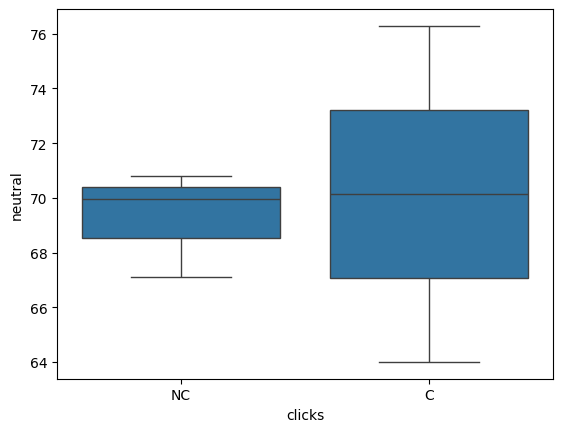

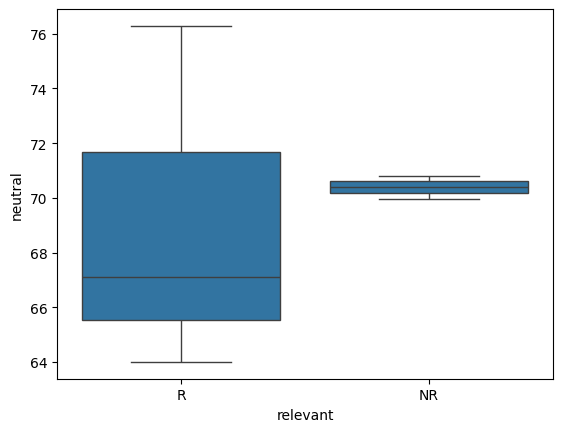

In [920]:
import seaborn as sns
import matplotlib.pyplot as plt

merged_df = pd.merge(query_log, EP_df, on=["query", "textsample"])
metric = "neutral"

g = sns.boxplot(data = merged_df, y=metric, x="click")
g.set_ylabel(metric)
g.set_xlabel("clicks")
file_name = metric+"_click.pdf"
# plt.savefig("./figures/"+file_name, dpi=400, bbox_inches="tight")
plt.show()

g = sns.boxplot(data = merged_df, y=metric, x="relevant")
g.set_ylabel(metric)
g.set_xlabel("relevant")
file_name = metric+"_relevant.pdf"
# plt.savefig("./figures/"+file_name, dpi=400, bbox_inches="tight")
plt.show()

# g = sns.boxplot(data = merged_df, y=metric, x="relevant_click")
# g.set_ylabel("")
# g.set_xlabel("")
# file_name = metric+"_relevant_click.pdf"
# # plt.savefig("./figures/"+file_name, dpi=400, bbox_inches="tight")
# plt.show()